In [1]:
# to do : try with dat, dat_norm
# note: it seems like the data eeds to be normalized
# in order for the inverse transform to look like the data.
# note: the shaded region is the "cone of influence"

# to do: experiment with different wavelets.


# note: a higher J than the example helped decrease the model residuals
# which makes sense, because the spectrum is composed of a larger range of wavelet scales
# also, I think removing large J removes larger scales that the continuum is captured by

# note: the gaussian wavelet looks more like
# the figures form the other day,
# but the residuals between the spectrum and inverse transform have higher residuals
# maybe I can tweak these parameters.
# but for now I'm going to move forward with the morlet.

In [2]:
# need t, iwav, dat
from astropy.io import fits
import pandas as pd
import numpy
from matplotlib import pyplot
import pycwt as wavelet
%pylab inline

training_flux = pd.read_csv('./training_flux.csv')
w_full = fits.open('./data/w_to_resample_to_i_chip.fits')[0].data
# idx = (w_full>6680) & (w_full<6780)
idx = (w_full>6670) & (w_full<6785)
w = w_full[idx]

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [20]:
# store variables with same names as tutorial
t = w
dt = w[1]-w[0]
t0 = w[0]
dat = training_flux['K00155'].to_numpy()[idx]


# store plotting information
title = 'normalized flux'
label = r'$f_{\lambda}$'
units = 'counts'

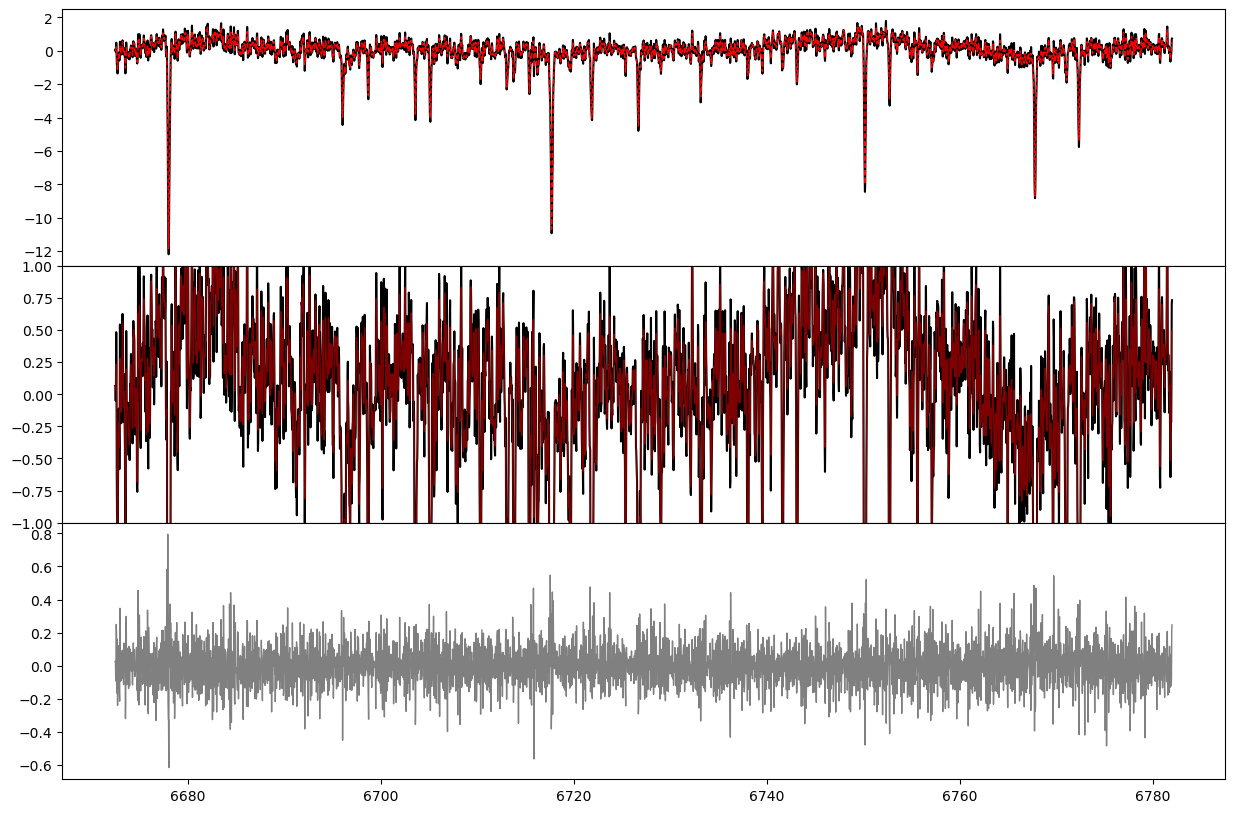

In [21]:
# normalize data
p = numpy.polyfit(t - t0, dat, 1)
dat_notrend = dat - numpy.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset
N = dat.size

# The next step is to define some parameters of our wavelet analysis. We
# select the mother wavelet, in this case the Morlet wavelet with
# :math:`\omega_0=6`.
# NOTE: wavelet.DOG(m=2) with s0=1*dt works too
# mother = wavelet.Morlet(6)
mother = wavelet.MexicanHat()
dj = 1 / 12  # Twelve sub-octaves per octaves
s0 = 1 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
J = 12 / dj  # 11 powers of two with dj sub-octaves (same as swt)
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

# compute wavelet transform data
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother)

# information for contour map
power = (numpy.abs(wave)) ** 2 # normalized wavelet spectrum
fft_power = numpy.abs(fft) ** 2 #  Fourier power spectrum
period = 1 / freqs # Fourier equivalent periods for each wavelet scale.
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95 # power is significant where power/sig95>1



glbl_power = power.mean(axis=1) # gloabl wavelet power
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother) # gloabl wavelet power significance level


figure(figsize=(15,10))
subplot(311)
plot(t, dat_norm, 'k', linewidth=1.5)
plot(t, iwave, 'r--', linewidth=1)
subplot(312)
plot(t, dat_norm, 'k', linewidth=1.5)
plot(t, iwave, 'r', linewidth=1, alpha=0.5)
ylim(-1,1)
subplot(313)
plot(t, dat_norm - iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
subplots_adjust(hspace=0)

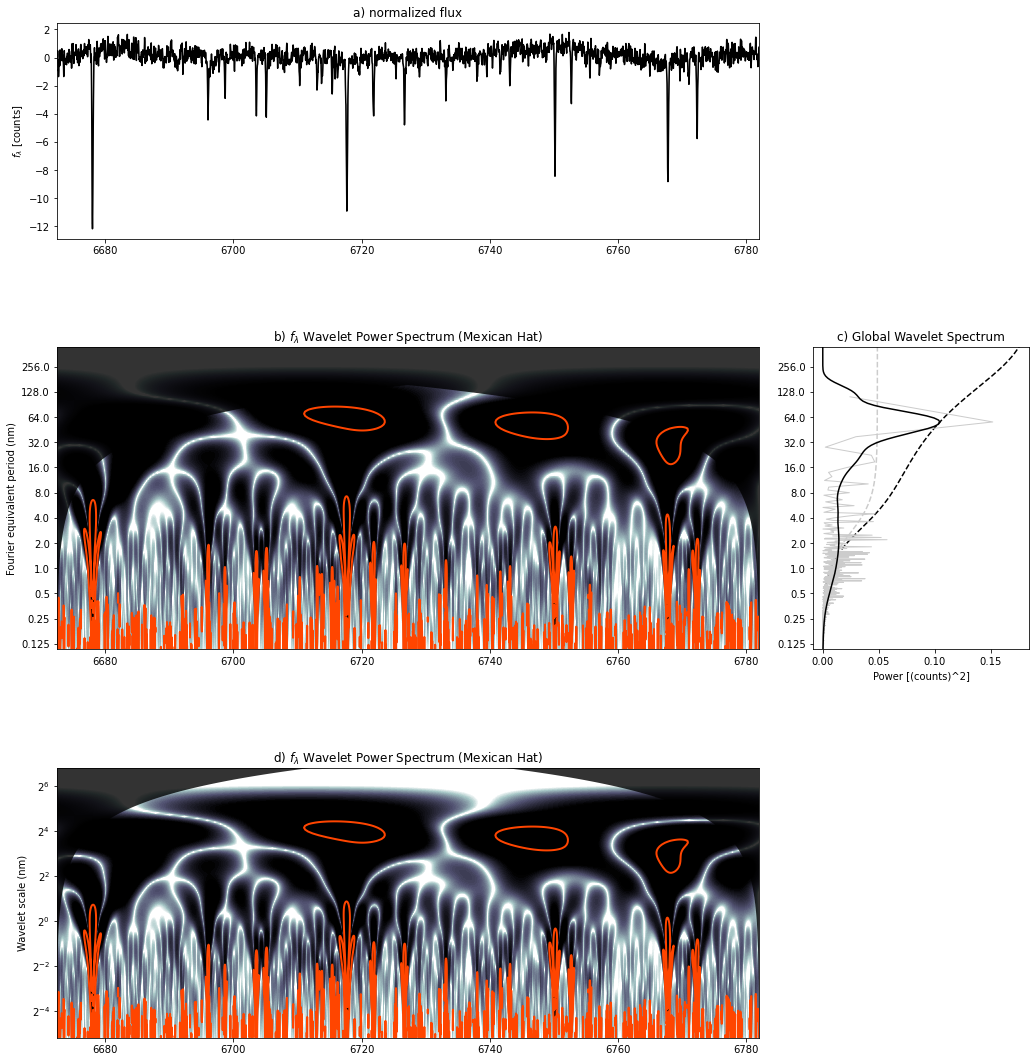

In [22]:
# Prepare the figure
figprops = dict(figsize=(15, 15), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat_norm, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))


# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
# levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
# levels = np.logspace(-4,4,base=2, num=9)
levels = np.logspace(-4,4,base=2, num=50)
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.bone_r)
extent = [t.min(), t.max(), min(period), max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='orangered', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.8)
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Fourier equivalent period (nm)')

Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)
bx.set_ylim(np.log2(period.min()), np.log2(period.max()))

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.80, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--')
cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
# # cx.set_xlim([0, glbl_power.max() + var])
# # cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
# cx.set_yticklabels([])
cx.set_yticklabels(Yticks)
# setp(cx.get_yticklabels(), visible=False)

# same as plot above, but with wavelet scale instead of period
# NOTE: I can probably change scales to log2(scales)
# and then remove the logscale commands
dx = pyplot.axes([0.1, 0.01, 0.65, 0.25], sharex=ax)
dx.contourf(t, scales, numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.bone_r)
extent = [t.min(), t.max(), min(scales), max(scales)]
dx.contour(t, scales, sig95, [-99, 1], colors='orangered', linewidths=2,
           extent=extent)
dx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([coi, [1e-9], period[-1:],
                           period[-1:], [1e-9]]),
        'k', alpha=0.8)

Yticks = 2 ** numpy.arange(numpy.ceil(scales.min()),
                           numpy.ceil(scales.max()))

dx.set_title('d) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
dx.set_ylabel('Wavelet scale (nm)')
dx.set_yticks(Yticks)
dx.set_yticklabels(Yticks)
dx.set_ylim(scales.min(), scales.max())
dx.set_yscale('log', base=2)

0 0.12875166989237632 0.243050787852574
1 0.25750333978475265 0.486101575705148
2 0.5150066795695053 0.972203151410296
3 1.0300133591390106 1.9444063028205916
4 2.060026718278021 3.888812605641183
5 4.120053436556042 7.777625211282366
6 8.240106873112085 15.555250422564733
7 16.48021374622417 31.110500845129465
8 32.96042749244834 62.22100169025893
9 65.92085498489668 124.44200338051786
10 131.84170996979336 248.88400676103572


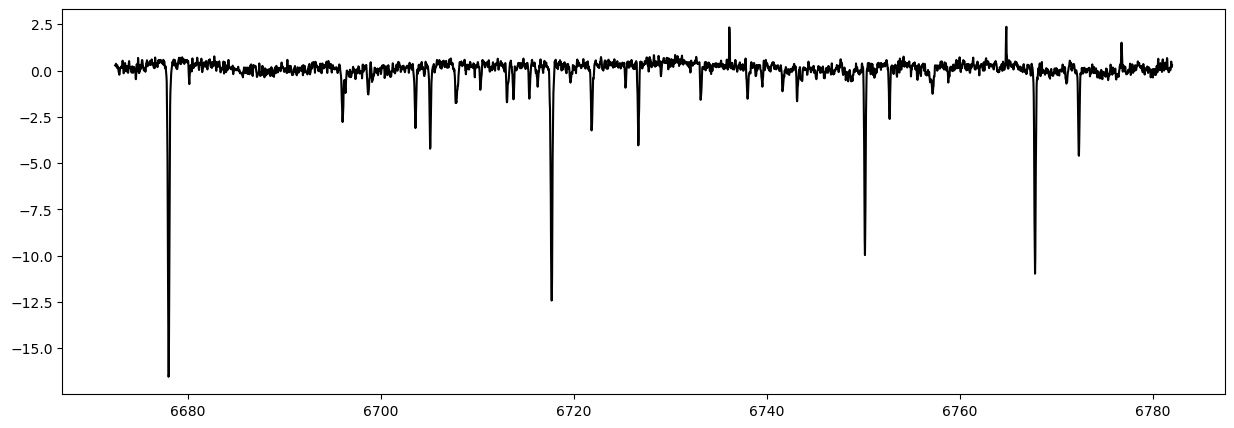

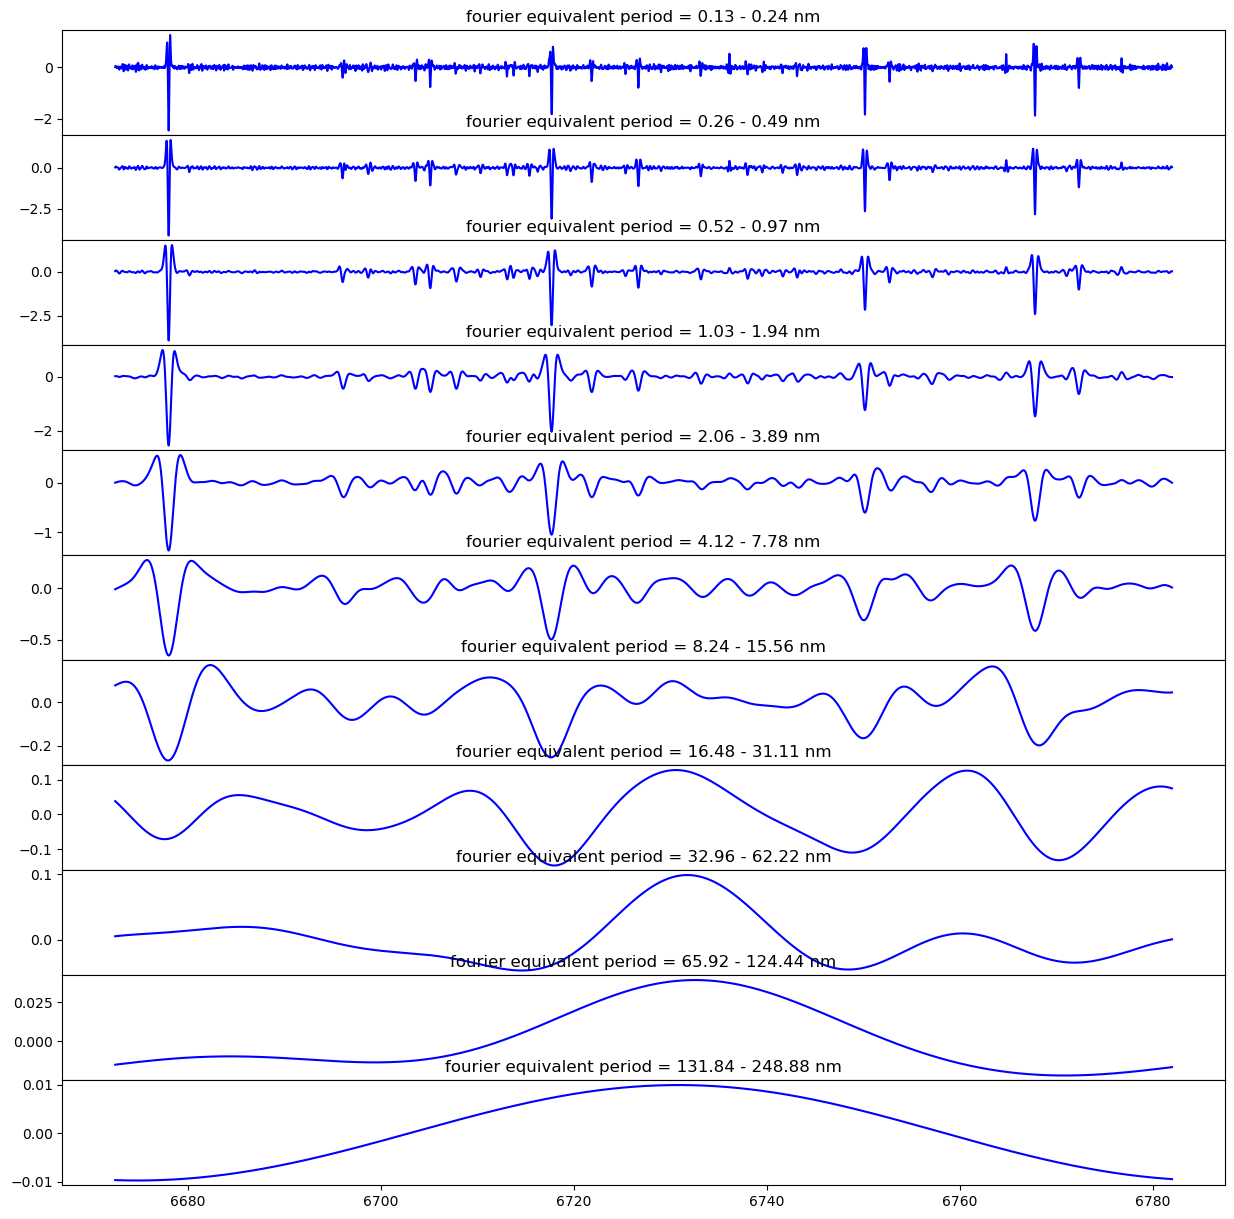

In [6]:
# three things:
# (1) I think if I print the period bin edges, it excludes some of the periods on the y axis
# (see print statements)
# (2) is it a problem that some of these are in the cone of influence?
# (3) is this the best way to take slices?
# (4) it also looks like the transform isn't preserving the spectral line depths

figure(figsize=(15,5))
plot(t, dat_norm, color='k')


period_slice_edges = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())),1)

fig, ax = plt.subplots(len(period_slice_edges)-1, 1, figsize=(15,15))
for i in range(len(period_slice_edges)-1):
    period_start = period_slice_edges[i]
    period_stop = period_slice_edges[i+1]
    
    period_slice_idx = (period >= period_start) & (period <= period_stop)
    iwave_slice = wavelet.icwt(wave[period_slice_idx], scales[period_slice_idx], dt, dj, mother)
    period_slice = period[period_slice_idx]
    
    ax[i].plot(t, iwave_slice, 'b-')
    title_str = 'fourier equivalent period = {} - {} nm'.format(
        np.round(period_slice[0],2),
        np.round(period_slice[-1],2))
    print(i, period_slice[0], period_slice[-1])
    ax[i].set_title(title_str)

    
subplots_adjust(hspace=0)

In [7]:
period_edge_slices

NameError: name 'period_edge_slices' is not defined

In [ ]:
# finally, what happens when I re-construct a spetrum without the larger scale wavelets?
# this does look like the continuum...
# I don't really see the continuum being isolated here.
# so for a star with a lot of continuum behavior, the inverse wavelet transform helped!
period_start = 0
period_stop = 16
    
period_slice_idx = (period >= period_start) & (period <= period_stop)
iwave_slice = wavelet.icwt(wave[period_slice_idx], scales[period_slice_idx], dt, dj, mother)

figure(figsize=(15,10))
subplot(211)
plot(t, dat_norm, color='c')
plot(t, iwave_slice, color='tomato')
# axhline(0, color='k',ls='--')
# subplot(212)
# plot(t, dat_norm-iwave_slice, color='tomato')

In [ ]:
# next: I want to make a plot of these for the 3 keck spectra of Kepler-1656

Text(0, 0.5, 'abcdefghijkl')

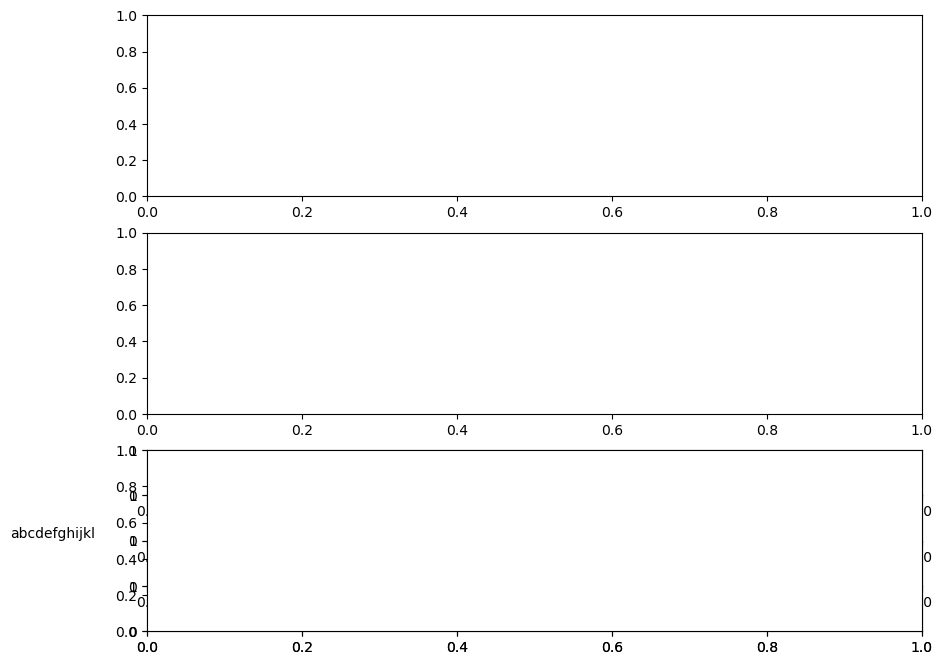

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 8))
outer = gridspec.GridSpec(3, 1, wspace=0.2, hspace=0.2)

ax = plt.Subplot(fig, outer[0])
fig.add_subplot(ax)

bx = plt.Subplot(fig, outer[1])
fig.add_subplot(bx)

cx = plt.Subplot(fig, outer[2])

inner = gridspec.GridSpecFromSubplotSpec(4, 1,
                 subplot_spec=cx, wspace=0, hspace=0)
for i in range(4):
    cx_i = plt.Subplot(fig, inner[i])
    fig.add_subplot(cx_i)
fig.add_subplot(cx)
cx.set_ylabel('abcdefghijkl', rotation=0, labelpad=45)
# for i in range(4):
#     inner = gridspec.GridSpecFromSubplotSpec(2, 1,
#                 subplot_spec=cx, wspace=0.1, hspace=0.1)
#     cx_i = plt.Subplot(fig, inner[i])

# fig.add_subplot(cx)

# for i in range(4):
#     inner = gridspec.GridSpecFromSubplotSpec(2, 1,
#                     subplot_spec=outer[i], wspace=0.1, hspace=0.1)

#     for j in range(2):
#         ax = plt.Subplot(fig, inner[j])
#         t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i, j))
#         t.set_ha('center')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         fig.add_subplot(ax)